In [1]:
import glob
import pandas as pd
import cv2
import gc
import numpy as np
import random
import imageio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras.models import load_model
from IPython.display import Image as DisplayImage
from io import BytesIO
import seaborn as sn
from sklearn import metrics
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from tensorflow.keras.callbacks import Callback

2025-07-11 15:27:02.042764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752247622.225716      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752247622.278234      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_35/2009219347.py:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
#full ucf50
'''class CFG:
    epochs = 20
    batch_size = 8
    classes = ["BaseballPitch", "Basketball", "BenchPress", "Biking", "Billiards", "BreastStroke",
               "CleanandJerk", "Diving", "Drumming", "Fencing", "GolfSwing", "HighJump",
               "HorseRace", "HorseRiding", "HulaHoop", "JavelinThrow", "JugglingBalls",
               "JumpRope", "JumpingJack", "Kayaking", "Lunges", "MilitartParade",
               "Mixing", "Nunchucks", "PizzaTossing", "PlayingGuitar", "PlayingPiano",
               "PlayingTabla", "PlayingViolin", "PoleVault", "PommelHorse", "PullUps",
               "Punch", "PushUps", "RockClimbingIndoor", "RopeClimbing", "Rowing", 
               "SalsaSpin", "SkateBoarding", "Skiing", "Skijet", "SoccerJuggling", 
               "Swing", "TaiChi", "TennisSwing", "ThrowDiscus", "TrampolineJumping", 
               "VolleyballSpiking", "WalkingWithDog", "YoYo"]'''

'class CFG:\n    epochs = 20\n    batch_size = 8\n    classes = ["BaseballPitch", "Basketball", "BenchPress", "Biking", "Billiards", "BreastStroke",\n               "CleanandJerk", "Diving", "Drumming", "Fencing", "GolfSwing", "HighJump",\n               "HorseRace", "HorseRiding", "HulaHoop", "JavelinThrow", "JugglingBalls",\n               "JumpRope", "JumpingJack", "Kayaking", "Lunges", "MilitartParade",\n               "Mixing", "Nunchucks", "PizzaTossing", "PlayingGuitar", "PlayingPiano",\n               "PlayingTabla", "PlayingViolin", "PoleVault", "PommelHorse", "PullUps",\n               "Punch", "PushUps", "RockClimbingIndoor", "RopeClimbing", "Rowing", \n               "SalsaSpin", "SkateBoarding", "Skiing", "Skijet", "SoccerJuggling", \n               "Swing", "TaiChi", "TennisSwing", "ThrowDiscus", "TrampolineJumping", \n               "VolleyballSpiking", "WalkingWithDog", "YoYo"]'

In [3]:
#full ucf101
class CFG:
    epochs = 20
    batch_size = 8
    classes = ["ApplyEyeMakeup", "ApplyLipstick", "Archery", "BabyCrawling", 
               "BalanceBeam", "BandMarching", "BaseballPitch", "Basketball", 
               "BasketballDunk", "BenchPress", "Biking", "Billiards", 
               "BlowDryHair", "BlowingCandles", "BodyWeightSquats", "Bowling", 
               "BoxingPunchingBag", "BoxingSpeedBag", "BreastStroke", "BrushingTeeth", 
               "CleanAndJerk", "CliffDiving", "CricketBowling", "CricketShot", 
               "CuttingInKitchen", "Diving", "Drumming", "Fencing", "FieldHockeyPenalty", 
               "FloorGymnastics", "FrisbeeCatch", "FrontCrawl", "GolfSwing", "Haircut", 
               "HammerThrow", "Hammering", "HandstandPushups", "HandstandWalking", 
               "HeadMassage", "HighJump", "HorseRace", "HorseRiding", "HulaHoop", 
               "IceDancing", "JavelinThrow", "JugglingBalls", "JumpRope", "JumpingJack", 
               "Kayaking", "Knitting", "LongJump", "Lunges", "MilitaryParade", "Mixing", 
               "MoppingFloor", "Nunchucks", "ParallelBars", "PizzaTossing", "PlayingGuitar", 
               "PlayingPiano", "PlayingTabla", "PlayingViolin", "PlayingCello", "PlayingDaf", 
               "PlayingDhol", "PlayingFlute", "PlayingSitar", "PoleVault", "PommelHorse", 
               "PullUps", "Punch", "PushUps", "Rafting", "RockClimbingIndoor", 
               "RopeClimbing", "Rowing", "SalsaSpins", "ShavingBeard", "Shotput", 
               "SkateBoarding", "Skiing", "Skijet", "SkyDiving", "SoccerJuggling", 
               "SoccerPenalty", "StillRings", "SumoWrestling", "Surfing", "Swing", 
               "TableTennisShot", "TaiChi", "TennisSwing", "ThrowDiscus", 
               "TrampolineJumping", "Typing", "UnevenBars", "VolleyballSpiking", 
               "WalkingWithDog", "WallPushups", "WritingOnBoard", "YoYo"]

  0%|          | 0/13187 [00:00<?, ?it/s]

I0000 00:00:1752247636.776877      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


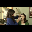

13187
for training:  9230 9230
for validation:  1187 1187
for testing:  2770 2770


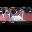

9


25

In [4]:
#Pad and resize an image from a video
def format_frames(frame, output_size):
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

#Creates frames from each video file present for each category
def frames_from_video_file(video_path, n_frames, output_size = (32,32), frame_step = 5): #frame_step = 15
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

# Create a list to store the frames
def to_gif(images):
    frames = []
    
    # Convert and append each image as a frame
    for image in images:
        # Assuming the images are numpy arrays
        converted_image = Image.fromarray(np.clip(image * 255, 0, 255).astype(np.uint8))
        frames.append(converted_image)
    
    # Create an in-memory file object
    gif_bytes = BytesIO()
    
    # Save frames as an animated GIF
    frames[0].save(gif_bytes, format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)
            
    display_gif(gif_bytes.getvalue())

# Display the animated GIF
def display_gif(data):
    display(DisplayImage(data=data, format='gif'))
    #with open("test2.gif", "wb") as png:
    #    png.write(data)

file_paths = []
targets = []
for i, cls in enumerate(CFG.classes):
    #full ucf50
    #sub_file_paths = glob.glob(f"/kaggle/input/ucf50/UCF50/{cls}/**.avi")
    sub_file_paths = glob.glob(f"/kaggle/input/ucf101/UCF101/UCF-101/{cls}/**.avi")
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)

features = []
for file_path in tqdm(file_paths):
    if file_path == "/kaggle/input/ucf11dataset/UCF11_updated_mpg/basketball/v_shooting_25/v_shooting_25_06.mpg":
        continue
    features.append(frames_from_video_file(file_path, n_frames = 30))  #50 
to_gif(features[0])
features = np.array(features)
print(len(features))

train_features, rest_features, train_targets, rest_targets = train_test_split(features, targets, test_size=0.3, random_state=42)
val_features, test_features, val_targets, test_targets = train_test_split(rest_features, rest_targets, test_size=0.7, random_state=42)

print("for training: ",len(train_features),len(train_targets))
print("for validation: ",len(val_features),len(val_targets))
print("for testing: ",len(test_features),len(test_targets))
to_gif(val_features[2])
print(val_targets[2])
del features
del rest_features
del rest_targets

train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_targets)).shuffle(CFG.batch_size * 4).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((val_features, val_targets)).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)
test_ds =  tf.data.Dataset.from_tensor_slices((test_features, test_targets)).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)
del train_targets
del train_features
del val_features
del val_targets
del test_features
del test_targets
gc.collect()

# ****Model 1****

In [5]:
'''
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(30, 32, 32, 3)))  # Fixed input shape
    
    # Tune Conv3D layers
    for i in range(hp.Int('num_conv_layers', 3, 5)):
        model.add(tf.keras.layers.Conv3D(
            filters=hp.Int(f'filters_{i}', min_value=32, max_value=256, step=10),
            kernel_size=(3, 3, 3),
            strides=1,
            padding='same',
            activation='relu'
        ))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPool3D(
            pool_size=(2, 2, 2),
            strides=2,
            padding='same'
        ))
        
        if hp.Choice(f'add_dropout_{i}', [True, False]):
            model.add(tf.keras.layers.Dropout(
                rate=hp.Float(f'dropout_rate_{i}', 0.1, 0.5)
            ))
    
    model.add(tf.keras.layers.Flatten())
    
    # Tune dense layer
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=5),
        activation='relu'
    ))
    
    model.add(tf.keras.layers.Dense(len(CFG.classes), activation='softmax'))
    
    # Tune learning rate
    learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

# Initialize Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=15,
    directory='hyperband_tuning',
    project_name='ucf50_action_recognition'
)

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(
    train_ds,
    epochs=50,
    validation_data=valid_ds,
    callbacks=[early_stop, checkpoint]
)

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train best model
model = build_model(best_hp)

filename='histroylog.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

model.summary()

# Fit best model manually and log history
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=50,
    callbacks=[checkpoint, early_stop, history_logger]
)

# Convert training history to DataFrame
df = pd.DataFrame(history.history)

# Plot training vs validation loss and accuracy
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    df[list(metrics)].plot()
    plt.title(f'{metrics[0]} vs {metrics[1]}')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

y_true = []
y_pred = []

# Loop over test dataset
for x_batch, y_batch in test_ds:
    # Predict probabilities
    preds = model.predict(x_batch, verbose=0)
    
    # Get predicted class indices
    pred_classes = np.argmax(preds, axis=1)
    
    y_pred.extend(pred_classes)
    y_true.extend(y_batch.numpy())  # labels are already integers

print(classification_report(y_true, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, fmt="d", cmap="viridis")  # or use cmap="plasma", "inferno", etc.
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
'''

'\ndef build_model(hp):\n    model = tf.keras.Sequential()\n    model.add(tf.keras.Input(shape=(30, 32, 32, 3)))  # Fixed input shape\n    \n    # Tune Conv3D layers\n    for i in range(hp.Int(\'num_conv_layers\', 3, 5)):\n        model.add(tf.keras.layers.Conv3D(\n            filters=hp.Int(f\'filters_{i}\', min_value=32, max_value=256, step=10),\n            kernel_size=(3, 3, 3),\n            strides=1,\n            padding=\'same\',\n            activation=\'relu\'\n        ))\n        model.add(tf.keras.layers.BatchNormalization())\n        model.add(tf.keras.layers.MaxPool3D(\n            pool_size=(2, 2, 2),\n            strides=2,\n            padding=\'same\'\n        ))\n        \n        if hp.Choice(f\'add_dropout_{i}\', [True, False]):\n            model.add(tf.keras.layers.Dropout(\n                rate=hp.Float(f\'dropout_rate_{i}\', 0.1, 0.5)\n            ))\n    \n    model.add(tf.keras.layers.Flatten())\n    \n    # Tune dense layer\n    model.add(tf.keras.layers.Dens

In [6]:
'''test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_acc:.3f}")'''

'test_loss, test_acc = model.evaluate(test_ds)\nprint(f"\nTest accuracy: {test_acc:.3f}")'

# ****Model 2****

In [7]:
'''
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(30, 32, 32, 3)))  # Fixed input shape
    
    # Tune Conv3D layers
    for i in range(hp.Int('num_conv_layers', 3, 5)):
        model.add(tf.keras.layers.Conv3D(
            filters=hp.Int(f'filters_{i}', min_value=32, max_value=256, step=10),
            kernel_size=(3, 3, 3),
            strides=1,
            padding='same',
            activation='relu'
        ))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPool3D(
            pool_size=(2, 2, 2),
            strides=2,
            padding='same'
        ))
        
        if hp.Choice(f'add_dropout_{i}', [True, False]):
            model.add(tf.keras.layers.Dropout(
                rate=hp.Float(f'dropout_rate_{i}', 0.1, 0.5)
            ))
    
    model.add(tf.keras.layers.Flatten())
    
    # Tune dense layer
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=10),
        activation='relu'
    ))
    
    model.add(tf.keras.layers.Dense(len(CFG.classes), activation='softmax'))
    
    # Tune learning rate
    learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

# Initialize Bayesian Optimization tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Maximum number of trials to run
    num_initial_points=10,  # Random exploration before Bayesian optimization
    directory='bayesian_tuning',
    project_name='ucf50_action_recognition'
)

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5", monitor="val_accuracy", mode="max",
    save_best_only=True, verbose=1
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Perform hyperparameter search
tuner.search(
    train_ds,
    validation_data=valid_ds,
    epochs=50,
    callbacks=[checkpoint, early_stop]
)

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate on test set
#test_loss, test_acc = best_model.evaluate(test_ds)
#print(f"\nTest accuracy: {test_acc:.3f}")

# Optional: Retrain best model with full training data
history = best_model.fit(tf.data.Dataset.concatenate(train_ds, valid_ds), 
               epochs=CFG.epochs*2, validation_data=valid_ds)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Loop over test dataset
for x_batch, y_batch in test_ds:
    # Predict probabilities
    preds = best_model.predict(x_batch, verbose=0)
    
    # Get predicted class indices
    pred_classes = np.argmax(preds, axis=1)
    
    y_pred.extend(pred_classes)
    y_true.extend(y_batch.numpy())  # labels are already integers

print(classification_report(y_true, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, fmt="d", cmap="viridis")  # or use cmap="plasma", "inferno", etc.
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

test_loss, test_acc = best_model.evaluate(test_ds)
print(f"\nTest accuracy: {test_acc:.3f}")
'''

'\ndef build_model(hp):\n    model = tf.keras.Sequential()\n    model.add(tf.keras.Input(shape=(30, 32, 32, 3)))  # Fixed input shape\n    \n    # Tune Conv3D layers\n    for i in range(hp.Int(\'num_conv_layers\', 3, 5)):\n        model.add(tf.keras.layers.Conv3D(\n            filters=hp.Int(f\'filters_{i}\', min_value=32, max_value=256, step=10),\n            kernel_size=(3, 3, 3),\n            strides=1,\n            padding=\'same\',\n            activation=\'relu\'\n        ))\n        model.add(tf.keras.layers.BatchNormalization())\n        model.add(tf.keras.layers.MaxPool3D(\n            pool_size=(2, 2, 2),\n            strides=2,\n            padding=\'same\'\n        ))\n        \n        if hp.Choice(f\'add_dropout_{i}\', [True, False]):\n            model.add(tf.keras.layers.Dropout(\n                rate=hp.Float(f\'dropout_rate_{i}\', 0.1, 0.5)\n            ))\n    \n    model.add(tf.keras.layers.Flatten())\n    \n    # Tune dense layer\n    model.add(tf.keras.layers.Dens

# ****Model 3****

In [ ]:

def build_model(hp):
    inputs = layers.Input(shape=(30, 32, 32, 3))  # (frames, height, width, channels)

    # Conv3D Block 1
    x = layers.Conv3D(
        filters=hp.Int("conv3d_filters_1", 32, 96, step=16),
        kernel_size=(3, 3, 3),
        activation="relu",
        padding="same",
        kernel_regularizer=l2(hp.Choice("l2_reg", [1e-4, 1e-5]))
    )(inputs)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.BatchNormalization()(x)

    # Conv3D Block 2
    x = layers.Conv3D(
        filters=hp.Int("conv3d_filters_2", 64, 128, step=16),
        kernel_size=(3, 3, 3),
        activation="relu",
        padding="same",
        kernel_regularizer=l2(hp.Choice("l2_reg", [1e-4, 1e-5]))
    )(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.BatchNormalization()(x)

    # Conv3D Block 3
    x = layers.Conv3D(
        filters=hp.Int("conv3d_filters_3", 64, 128, step=16),
        kernel_size=(3, 3, 3),
        activation="relu",
        padding="same",
        kernel_regularizer=l2(hp.Choice("l2_reg", [1e-4, 1e-5]))
    )(x)
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Reshape((1, -1))(x)

    # Bidirectional LSTM
    lstm_units = hp.Int("lstm_units", 128, 512, step=64)
    x = layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True)
    )(x)

    # Attention Mechanism
    attention = layers.Dense(1, activation='tanh')(x)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(lstm_units * 2)(attention)
    attention = layers.Permute([2, 1])(attention)
    x = layers.multiply([x, attention])
    x = layers.Lambda(lambda xin: tf.reduce_sum(xin, axis=1))(x)

    # Fully Connected Layer
    x = layers.Dense(
        units=hp.Int("dense_units", 128, 512, step=64),
        activation='relu',
        kernel_regularizer=l2(hp.Choice("l2_reg", [1e-4, 1e-5]))
    )(x)
    x = layers.Dropout(hp.Float("dropout", 0.3, 0.6, step=0.1))(x)

    # Output Layer
    outputs = layers.Dense(len(CFG.classes), activation='softmax')(x)

    model = models.Model(inputs, outputs)

    # Optimizer
    optimizer_choice = hp.Choice("optimizer", ["adam", "adamw", "rmsprop"])
    learning_rate = hp.Choice("learning_rate", [1e-3, 5e-4, 3e-4, 1e-4, 1e-5])

    if optimizer_choice == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate)
    elif optimizer_choice == "adamw":
        optimizer = tf.keras.optimizers.AdamW(learning_rate)
    elif optimizer_choice == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define tuner
tuner = RandomSearch(
    build_model,                       # your model-building function
    objective='val_accuracy',
    max_trials=6, #20,                    # total different combinations to try
    #executions_per_trial=1,           # number of times to train each combination
    directory='video_model_tuning',
    project_name='3dcnn_lstm_attention'
)

# Optional: early stopping and LR reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)
# Run tuner search
tuner.search(
    train_ds,
    epochs=50,
    validation_data=valid_ds,
    callbacks=[early_stop, reduce_lr, checkpoint]  # add all callbacks
)

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train best model
model = build_model(best_hp)

model.summary()



# Fit best model manually and log history
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=50,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

# Convert training history to DataFrame
df = pd.DataFrame(history.history)

# Plot training vs validation loss and accuracy
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    df[list(metrics)].plot()
    plt.title(f'{metrics[0]} vs {metrics[1]}')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

# Step 1: Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())               # Sparse integer labels
    y_pred.extend(np.argmax(preds, axis=1))     # Predicted class index

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt="d", cmap='viridis')  # You can change cmap if desired
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

test_loss, test_acc = model.evaluate(test_ds)

print(f"Test Loss:{test_loss} Testing Accuracy:{test_acc}")


Trial 1 Complete [00h 29m 03s]
val_accuracy: 0.45914068818092346

Best val_accuracy So Far: 0.45914068818092346
Total elapsed time: 00h 29m 03s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
80                |96                |conv3d_filters_1
1e-05             |0.0001            |l2_reg
112               |96                |conv3d_filters_2
128               |112               |conv3d_filters_3
128               |128               |lstm_units
448               |512               |dense_units
0.4               |0.3               |dropout
adamw             |rmsprop           |optimizer
0.0003            |1e-05             |learning_rate

Epoch 1/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0403 - loss: 4.3195
Epoch 1: val_accuracy improved from -inf to 0.12300, saving model to best_model.h5
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - accuracy: 0.0403 - loss: 4.3193 - val_accuracy: 0.1230 - val_loss: 3.6238 - learning_rate: 3.0000e-04

# ****Model 4****

In [ ]:
'''
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_addons as tfa


def build_enhanced_model(input_shape=(30, 32, 32, 3), num_classes=50):
    inputs = tf.keras.Input(shape=input_shape)

    # Spatial Feature Extraction
    x = tf.keras.layers.Conv3D(32, (3,3,3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool3D((1,2,2))(x)

    x = tf.keras.layers.Conv3D(64, (3,3,3), activation='selu', padding='same')(x)
    x = tf.keras.layers.SpatialDropout3D(0.25)(x)
    x = tf.keras.layers.MaxPool3D((1,2,2))(x)

    # Residual Block
    residual = tf.keras.layers.Conv3D(128, (1,1,1), padding='same')(x)
    x = tf.keras.layers.Conv3D(128, (3,3,3), activation='selu', padding='same')(x)
    x = tf.keras.layers.Add()([x, residual])
    x = tf.keras.layers.MaxPool3D((1,2,2))(x)

    # Temporal Modeling
    x = tf.keras.layers.Reshape((30, 4*4*128))(x)

    # Bidirectional GRU (reduced size)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(192, return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    )(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Attention with additional dropout
    attn = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = tf.keras.layers.Concatenate()([x, attn])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Classification Head
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(256, activation='selu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    # Cyclical Learning Rate with extended step size
    clr = tfa.optimizers.CyclicalLearningRate(
        initial_learning_rate=1e-4,
        maximal_learning_rate=1e-3,
        step_size=3000,
        scale_fn=lambda x: 1 / (2. ** (x - 1))
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=clr,
        weight_decay=1e-4,
        clipnorm=1.0
    )

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model



# Initialize model
model = build_enhanced_model()

model.summary()

callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True, monitor='val_accuracy'),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]
history = ""
history = model.fit(train_ds, validation_data=valid_ds, epochs=50, callbacks=callbacks)

model.load_weights("best_model.h5")

for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show()

test_loss, test_acc = model.evaluate(test_ds)

print(f"Test Loss:{test_loss} Testing Accuracy:{test_acc}")

# Step 1: Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())               # Sparse integer labels
    y_pred.extend(np.argmax(preds, axis=1))     # Predicted class index

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt="d", cmap='viridis')  # You can change cmap if desired
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
'''

In [ ]:
'''import tensorflow as tf
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model("/kaggle/input/model2h5/keras/default/1/best_model.h5")

# Display a summary in console
model.summary()

# Plot and save model architecture as an image
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)
'''